**OilyGiant mining company is looking to find the best place for a new well.**

The company provided steps to choose the location:

> **Step 1:** Collect the oil well parameters in the selected region: oil quality and volume of reserves;

> **Step 2:** Build a model for predicting the volume of reserves in the new wells;

> **Step 3:** Pick the oil wells with the highest estimated values;

> **Step 4:** Pick the region with the highest total profit for the selected oil wells.


**`Conditions:`**

- Only linear regression is suitable for model training (the rest are not sufficiently predictable).


- When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.


- The budget for development of 200 oil wells is 100 USD million.


- One barrel of raw materials brings 4.5 USD of revenue. The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).


- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.


- The data is synthetic: contract details and well characteristics are not disclosed.

We have data on oil samples from three regions and the parameters of each oil well in the region are already known. 

- We are to build a model that will help to pick the region with the highest profit margin. 


- Afterwards, we will analyze potential profit and risks using the Bootstrapping technique.

**`Data Source and Features:`**

Geological exploration data for the three regions are stored in files:
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

Features:
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- product — volume of reserves in the oil well (thousand barrels)

**`Preprocessing:`**

In [1]:
#library imports

import pandas as pd
import numpy as np
from numpy.random import RandomState
from math import floor, log
from scipy import stats as st


from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss

from sklearn.model_selection import check_cv, cross_validate, cross_val_predict, cross_val_score, learning_curve, validation_curve, train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import seaborn as sns

In [2]:
#data download

try:
    
    geo_data_0 = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML in Business/geo_data_0.csv')

    geo_data_1 = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML in Business/geo_data_1.csv')

    geo_data_2 = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML in Business/geo_data_2.csv')
    
except:
    
    print('There are issues with your data.')

**`Exploration:`**

In [3]:
#initializing data exploration

print('\x1B[1m' + 'Geography 0 - underlying information:'+ '\x1B[0m')
print('')
geo_data_0.info()
print('')

print('\x1B[1m' + 'Geography 1 - underlying information:'+ '\x1B[0m')
print('')
geo_data_1.info()
print('')

print('\x1B[1m' + 'Geography 2 - underlying information:'+ '\x1B[0m')
print('')
geo_data_2.info()

Geography 0 - underlying information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Geography 1 - underlying information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Geography 2 - underlying information:

<class 'panda

In [4]:
#initializing data statistics

print('\x1B[1m' + 'Geography 0 - underlying statistics:'+ '\x1B[0m')
geo_data_0.describe()

Geography 0 - underlying statistics:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
print('\x1B[1m' + 'Geography 1 - underlying statistics:'+ '\x1B[0m')
geo_data_1.describe()

Geography 1 - underlying statistics:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
print('\x1B[1m' + 'Geography 2 - underlying statistics:'+ '\x1B[0m')
geo_data_2.describe()

Geography 2 - underlying statistics:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**`Findings`**

1. Imported the fundamental libraries to manipulate data if needed as well as the model selection, metrics available to us and preprocessing aid.
    
    
2. The three data sets have the same amount of columns/entries and dtypes, no perceived NaN values. There's little reason to combine the data sets into one: they have different data distributions.
    
3. Can see variability off the bat when running `describe()` especially with the levels of magnitude for the values across the data sets (*oil quality*).
    
    
4. There are no duplicate rows but there are instances of id duplication for each data set (*the numeric features aren't the same*).

`geo_data_0`

In [7]:
#splitting the data into a training and validation set

features_0 = geo_data_0.drop(['id','product'], axis=1) # extracting features, removing redundant ('id')
target_0 = geo_data_0['product'] # extracting target

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

model = LinearRegression()
model.fit(features_train_0, target_train_0) # training the model
predicted_valid_0 = model.predict(features_valid_0) # collecting predictions


In [8]:
mse = mean_squared_error(target_valid_0, predicted_valid_0)

print('\x1B[1m' + 'Linear Regression:'+ '\x1B[0m')
print('MSE on validation set=', mse)
print('RMSE on validation set=', mse ** 0.5)


Linear Regression:
MSE on validation set= 1412.2129364399243
RMSE on validation set= 37.5794217150813


In [9]:
#sanity check with a constant model
#predicting the mean target value for each observation

predicted_valid_0_constant = pd.Series(target_train_0.mean(), index = target_valid_0.index)
mse = mean_squared_error(target_valid_0, predicted_valid_0_constant)

print('\x1B[1m' + 'Mean:'+ '\x1B[0m')
print('MSE =', mse)
print('RMSE =', mse ** 0.5)

#RMSE delta of ~7 points, oil reserve volume

Mean:
MSE = 1961.5678757223516
RMSE = 44.289591053907365


In [10]:
#average volume of predicted oil reserves

print('\x1B[1m' + 'Average Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(predicted_valid_0.mean()) #close to the value under our previous view into the data sets statistics

Average Prediction of Oil Reserve Volume:
92.59256778438035


In [11]:
#r2 metric
#greater than zero is good
#if metric increases, so does model quality

#benchmark
print('\x1B[1m' + 'R2 value starting point:'+ '\x1B[0m')
print('R2 =', r2_score(target_valid_0, predicted_valid_0))
print('')
print('\x1B[1m' + 'Comparing R2 value across training and validation set:'+ '\x1B[0m')
#r2 value on training set
print("R2 value on training set = ", model.score(features_train_0, target_train_0))
#r2 valu on validation set
print("R2 value on validation set = ", model.score(features_valid_0, target_valid_0))

#as expected, there is less possible overfitting/underfitting impact with the linear regression model

R2 value starting point:
R2 = 0.27994321524487786

Comparing R2 value across training and validation set:
R2 value on training set =  0.27423906493940775
R2 value on validation set =  0.27994321524487786


In [12]:
#mean absolute error


print('\x1B[1m' + 'Mean error for each observation:'+ '\x1B[0m')
print('MAE = ', mean_absolute_error(target_valid_0, predicted_valid_0))
#print('\x1B[1m' + 'Mean error for each observation in % terms:'+ '\x1B[0m')
#print('MAPE = ', mean_absolute_percentage_error(target_valid, predicted_valid))
#mean error for each observation is ~30


predicted_valid_0 = model.predict(features_valid_0)
predicted_train_0 = model.predict(features_train_0)

print('')
print('\x1B[1m' + 'Comparing MAE value across training and validation set:'+ '\x1B[0m')
#r2 value on training set
print("MAE value on training set = ", mean_absolute_error(target_train_0, predicted_train_0))
#r2 valu on validation set
print("MAE value on validation set = ", mean_absolute_error(target_valid_0, predicted_valid_0))


Mean error for each observation:
MAE =  30.919600777151324

Comparing MAE value across training and validation set:
MAE value on training set =  31.079961075786308
MAE value on validation set =  30.919600777151324


**`Findings`**

1. Comparing our benchmark model vs our constant model per our sanity check procedure, we find a difference under our RMSE of ~7 points which is the delta in oil reserve volume.
    
    
2. Our average predicted oil reserve volume comes out to about 92.59 which is very close to our initally inspected value using `describe()` in our earlier code block. Our average oil reserve was 92.50 in the data exploration phase.
    
    
3. R2 scores weren't the highest but were still above 0. We run a comparison across the training and validation set to compare results which reinforces how LinearRegression is more impervious to overfitting/underfitting.
    
    
4. Calculating MAE, we find ourselves with a mean error for each observation of about ~30 points with a similar story when comparing across the training and validation set (w/minimal deviation across both sets).

In [13]:
#average volume of predicted oil reserves

print('\x1B[1m' + 'Average Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(round(predicted_valid_0.mean())) #close to the value under our previous view into the data sets statistics

#comparing the above to the breakeven point
product_rev = 4500
budget = 100000000
breakeven = round(int(budget/product_rev)/200)
print('\x1B[1m' + 'Average Breakeven Point:'+ '\x1B[0m')
print(breakeven)


print('\x1B[1m' + 'Difference between Average Volume Prediction and Average Breakeven:'+ '\x1B[0m')
print(round(breakeven - predicted_valid_0.mean()))
breakeven_0 = breakeven - predicted_valid_0.mean()

Average Prediction of Oil Reserve Volume:
93
Average Breakeven Point:
111
Difference between Average Volume Prediction and Average Breakeven:
18


In [14]:
#function to format numbers into more readable instances

def revenue_format(number):
    units = ['', 'K', 'M', 'B', 'T']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '%.2f%s' % (number / k**magnitude, units[magnitude])


`geo_data_1`

In [15]:
#splitting the data into a training and validation set

features_1 = geo_data_1.drop(['id','product'], axis=1) # extracting features, removing redundant ('id')
target_1 = geo_data_1['product'] # extracting target

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)
model = LinearRegression()
model.fit(features_train_1, target_train_1) # training the model
predicted_valid_1 = model.predict(features_valid_1) # collecting predictions


In [16]:
mse = mean_squared_error(target_valid_1, predicted_valid_1)

print('\x1B[1m' + 'Linear Regression:'+ '\x1B[0m')
print('MSE on validation set=', mse)
print('RMSE on validation set=', mse ** 0.5)

#MSE and RMSE come out as decimals, standard scaling helps but ->
#have a feeling there is some sort of error here that eventually gets me to an R2 score of 0.99
#perhaps has to do with some of the min values in thed data set being around -30 which makes me doubt the scaling
#maybe normalizing does the trick instead?

#***refreshing kernel gives me values like 0.79 and 0.89 but once I run this code block that changes...***

Linear Regression:
MSE on validation set= 0.7976263360391147
RMSE on validation set= 0.8930992867756165


In [17]:
#sanity check with a constant model
#predicting the mean target value for each observation

predicted_valid_1_constant = pd.Series(target_train_1.mean(), index = target_valid_1.index)
mse = mean_squared_error(target_valid_1, predicted_valid_1_constant)

print('\x1B[1m' + 'Mean:'+ '\x1B[0m')
print('MSE =', mse)
print('RMSE =', mse ** 0.5)

#RMSE delta of ~6 points, oil reserve volume

Mean:
MSE = 2117.9734309299147
RMSE = 46.02144533725462


In [18]:
#average volume of predicted oil reserves

print('\x1B[1m' + 'Average Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(predicted_valid_1.mean()) #close to the value under our previous view into the data sets statistics

Average Prediction of Oil Reserve Volume:
68.728546895446


In [19]:
#r2 metric
#greater than zero is good
#if metric increases, so does model quality

#benchmark
print('\x1B[1m' + 'R2 value starting point:'+ '\x1B[0m')
print('R2 =', r2_score(target_valid_1, predicted_valid_1))
print('')
print('\x1B[1m' + 'Comparing R2 value across training and validation set:'+ '\x1B[0m')
#r2 value on training set
print("R2 value on training set = ", model.score(features_train_1, target_train_1))
#r2 valu on validation set
print("R2 value on validation set = ", model.score(features_valid_1, target_valid_1))


R2 value starting point:
R2 = 0.9996233978805127

Comparing R2 value across training and validation set:
R2 value on training set =  0.9996247760326118
R2 value on validation set =  0.9996233978805127


In [20]:
#mean absolute error

predicted_valid_1 = model.predict(features_valid_1)
predicted_train_1 = model.predict(features_train_1)

print('\x1B[1m' + 'Mean error for each observation:'+ '\x1B[0m')
print('MAE = ', mean_absolute_error(target_valid_1, predicted_valid_1))

#mean error for each observation is ~30

print('')
print('\x1B[1m' + 'Comparing MAE value across training and validation set:'+ '\x1B[0m')
#r2 value on training set
print("MAE value on training set = ", mean_absolute_error(target_train_1, predicted_train_1))
#r2 valu on validation set
print("MAE value on validation set = ", mean_absolute_error(target_valid_1, predicted_valid_1))

Mean error for each observation:
MAE =  0.7187662442124753

Comparing MAE value across training and validation set:
MAE value on training set =  0.7168438837861943
MAE value on validation set =  0.7187662442124753


In [21]:
#average volume of predicted oil reserves

print('\x1B[1m' + 'Average Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(round(predicted_valid_1.mean())) #close to the value under our previous view into the data sets statistics

#comparing the above to the breakeven point
product_rev = 4500
budget = 100000000
breakeven = round(int(budget/product_rev)/200)
print('\x1B[1m' + 'Average Breakeven Point:'+ '\x1B[0m')
print(breakeven)


print('\x1B[1m' + 'Difference between Average Volume Prediction and Average Breakeven:'+ '\x1B[0m')
print(round(breakeven - predicted_valid_1.mean()))
breakeven_1 = breakeven - predicted_valid_1.mean()

Average Prediction of Oil Reserve Volume:
69
Average Breakeven Point:
111
Difference between Average Volume Prediction and Average Breakeven:
42


`geo_data_2`

In [22]:
#splitting the data into a training and validation set

features_2 = geo_data_2.drop(['id','product'], axis=1) # extracting features, removing redundant ('id')
target_2 = geo_data_2['product'] # extracting target

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)
model = LinearRegression()
model.fit(features_train_2, target_train_2) # training the model
predicted_valid_2 = model.predict(features_valid_2) # collecting predictions


In [23]:
mse = mean_squared_error(target_valid_2, predicted_valid_2)

print('\x1B[1m' + 'Linear Regression:'+ '\x1B[0m')
print('MSE on validation set=', mse)
print('RMSE on validation set=', mse ** 0.5)

#same values here compared to geo_data_1, not sure why but I guess it's a possibility

Linear Regression:
MSE on validation set= 1602.3775813236196
RMSE on validation set= 40.02970873393434


In [24]:
#sanity check with a constant model
#predicting the mean target value for each observation

predicted_valid_2_constant = pd.Series(target_train_2.mean(), index = target_valid_2.index)
mse = mean_squared_error(target_valid_2, predicted_valid_2_constant)

print('\x1B[1m' + 'Mean:'+ '\x1B[0m')
print('MSE =', mse)
print('RMSE =', mse ** 0.5)

#RMSE delta of ~4 points, oil reserve volume

Mean:
MSE = 2016.2210072435087
RMSE = 44.90234968510566


In [25]:
#average volume of predicted oil reserves

print('\x1B[1m' + 'Average Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(predicted_valid_2.mean()) #close to the value under our previous view into the data sets statistics

Average Prediction of Oil Reserve Volume:
94.96504596800492


In [26]:
#r2 metric
#greater than zero is good
#if metric increases, so does model quality

#benchmark
print('\x1B[1m' + 'R2 value starting point:'+ '\x1B[0m')
print('R2 =', r2_score(target_valid_2, predicted_valid_2))
print('')
print('\x1B[1m' + 'Comparing R2 value across training and validation set:'+ '\x1B[0m')
#r2 value on training set
print("R2 value on training set = ", model.score(features_train_2, target_train_2))
#r2 valu on validation set
print("R2 value on validation set = ", model.score(features_valid_2, target_valid_2))


R2 value starting point:
R2 = 0.20524758386040443

Comparing R2 value across training and validation set:
R2 value on training set =  0.19661432867329998
R2 value on validation set =  0.20524758386040443


In [27]:
#mean absolute error

predicted_valid_2 = model.predict(features_valid_2)
predicted_train_2 = model.predict(features_train_2)

print('\x1B[1m' + 'Mean error for each observation:'+ '\x1B[0m')
print('MAE = ', mean_absolute_error(target_valid_2, predicted_valid_2))

#mean error for each observation is ~30

print('')
print('\x1B[1m' + 'Comparing MAE value across training and validation set:'+ '\x1B[0m')
#r2 value on training set
print("MAE value on training set = ", mean_absolute_error(target_train_2, predicted_train_2))
#r2 valu on validation set
print("MAE value on validation set = ", mean_absolute_error(target_valid_2, predicted_valid_2))

Mean error for each observation:
MAE =  32.79265210548182

Comparing MAE value across training and validation set:
MAE value on training set =  32.83941121639209
MAE value on validation set =  32.79265210548182


**`Findings`**

1. When comparing the RMSE, we see the lowest delta out of the regions with a ~4 point difference in oil reserve volume vs the constant model.
    
    
2. Average prediction for oil well volume is quite aligned to our initial observation when exploring the data. This value is higher than Region 0's average predicted volume.
    
    
3. R2 scores and MAE observations are somewhat similar to those under Region 0.

In [28]:
#average volume of predicted oil reserves

print('\x1B[1m' + 'Average Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(round(predicted_valid_2.mean())) #close to the value under our previous view into the data sets statistics

#comparing the above to the breakeven point
product_rev = 4500
budget = 100000000
breakeven = round(int(budget/product_rev)/200)
print('\x1B[1m' + 'Average Breakeven Point:'+ '\x1B[0m')
print(breakeven)


print('\x1B[1m' + 'Difference between Average Volume Prediction and Average Breakeven:'+ '\x1B[0m')
print(round(breakeven - predicted_valid_2.mean()))
breakeven_2 = breakeven - predicted_valid_2.mean()

Average Prediction of Oil Reserve Volume:
95
Average Breakeven Point:
111
Difference between Average Volume Prediction and Average Breakeven:
16


**`Findings`**

1. Conclusion from the breakeven analysis is that we are set to lose money in all Regions since breakeven is above ***all*** predicted volume amounts, w/o any bootstrapping or the selection of tops predictions. Meaning that as of right now, the model isn't very helpful, yet.

`Profit and Risk Calculation`

In [29]:
#creating a function to calculate profit from a set of selected oil wells and model predictions
#need to pick the wells with the highest values of predictions

def refined_profit_calc(target, predictions, count):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    budget = 100000000
    product_rev = 4500
    return (selected.sum() * product_rev) - budget

In [30]:
#region 0
predicted_valid_0 = pd.Series(predicted_valid_0).reset_index(drop=True)
target_valid_0 = pd.Series(target_valid_0).reset_index(drop=True)  
#region 1
predicted_valid_1 = pd.Series(predicted_valid_1).reset_index(drop=True)
target_valid_1 = pd.Series(target_valid_1).reset_index(drop=True)   
#region 2
predicted_valid_2 = pd.Series(predicted_valid_2).reset_index(drop=True)
target_valid_2 = pd.Series(target_valid_2).reset_index(drop=True)   

    
print('\x1B[1m' + 'Total Profit per Region (Top 200 Predictions - Oil Wells):'+ '\x1B[0m')
print('Region 0:', revenue_format(refined_profit_calc(target_valid_0, predicted_valid_0, 200)))
print('')
print('Region 1:', revenue_format(refined_profit_calc(target_valid_1, predicted_valid_1, 200)))
print('')
print('Region 2:', revenue_format(refined_profit_calc(target_valid_2, predicted_valid_2, 200)))
print('')

print('\x1B[1m' + 'Target Volume of Reserves (Top 200 Predictions - Oil Wells):'+ '\x1B[0m')
print('Region 0:', revenue_format(target_valid_0[predicted_valid_0.index][:200].sum()))
print('')
print('Region 1:', revenue_format(target_valid_1[predicted_valid_1.index][:200].sum()))
print('')
print('Region 2:', revenue_format(target_valid_2[predicted_valid_2.index][:200].sum()))
print('')

Total Profit per Region (Top 200 Predictions - Oil Wells):
Region 0: 33.21M

Region 1: 24.15M

Region 2: 27.10M

Target Volume of Reserves (Top 200 Predictions - Oil Wells):
Region 0: 18.18K

Region 1: 13.35K

Region 2: 18.92K



**`Findings`**
    
1. Region 0 brings in the most revenue taking into account cost which is a profit of $33M ($7M more than the next region). Target reserve volume varies across the regions with Region 2 having the highest overall target volume followed by Region 0.
    

2. If we are to pick the highest estimated values/highest profit from the predictions - the suggestion would be to focus on Region 0. While this region has a slightly higher delta between average prediction and the average breakeven point compared Region 2 (lower MAE however), it is predicted to bring a higher overall revenue when prediction the top 200 oil wells in our model.

3. The values are maximum profit values ***if*** we're lucky enough that all top 200 wells in the respective regions are contained in the small samples of 500 random locations.

In [31]:
def bootstrap(target, predictions, count):
    pred_sorted = predictions.reset_index(drop=True).sort_values(ascending=False)
    selected = target.reset_index(drop=True)[pred_sorted.index][:count]
    budget = 100000000
    product_rev = 4500
    return (selected.sum() * product_rev) - budget

`Distribution and Average Profit:`


Lower Quantile: -1112155.4589049604
Upper Quantile: 9097669.41553423
Mean: 3961649.8480237117
95% confidence interval: (3796203.1514797257, 4127096.5445676977)

Average Profit for Region 0:
3.96M

Profit Distribution for Region 0:


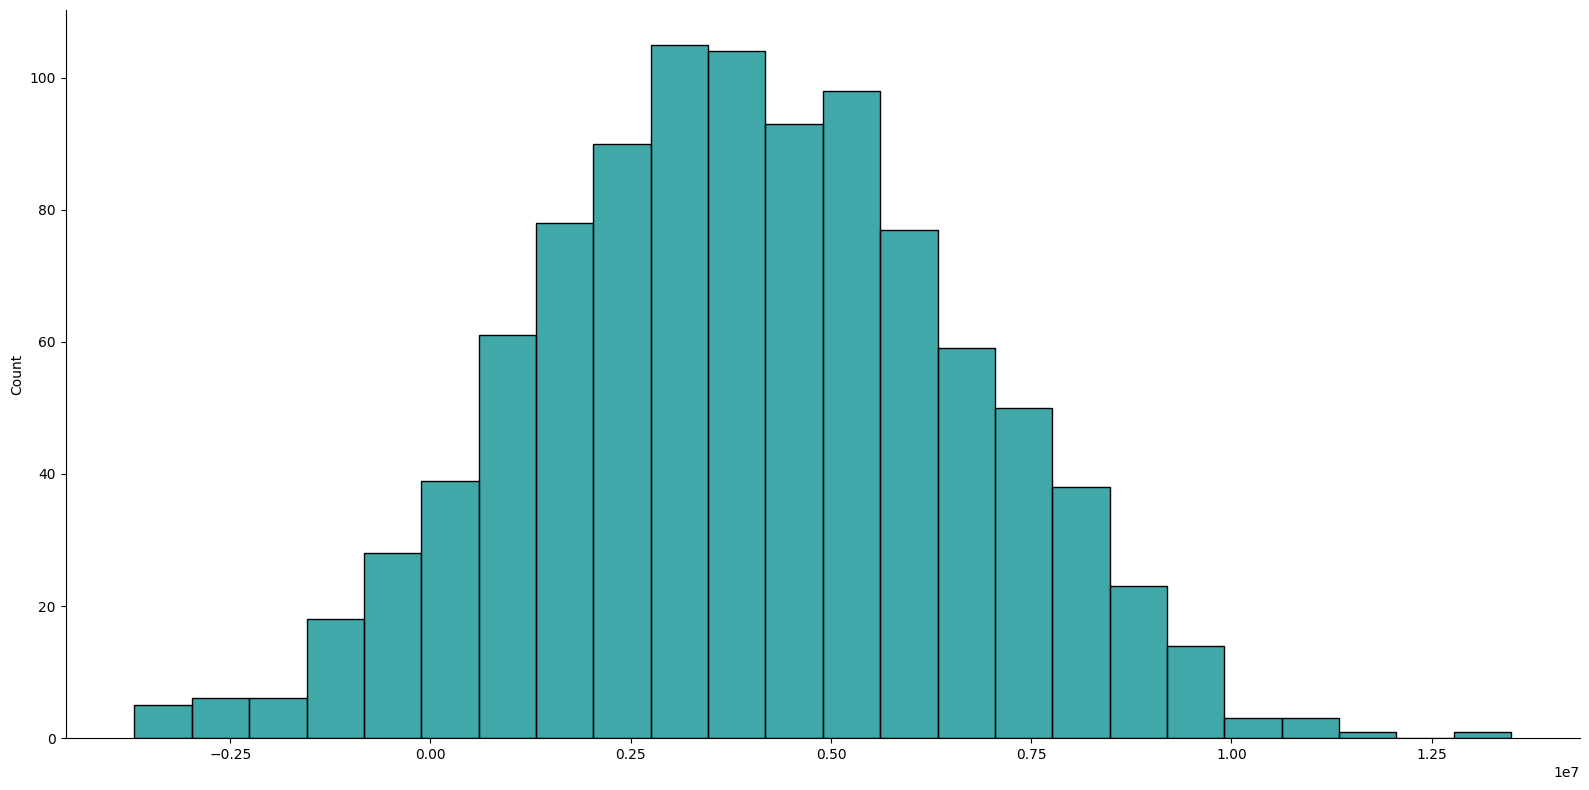

In [38]:
#confidence intervals/quantiles
state = np.random.RandomState(12345)

profit_0 = []
for i in range(1000):
    target_subsample_0 = target_valid_0.sample(n=500,replace=True, random_state=state)
    pred_subsample_0 = predicted_valid_0[target_subsample_0.index]
    #print(pred_subsample)
    profit_0.append(bootstrap(target_subsample_0, pred_subsample_0, 200))

profit_0 = pd.Series(profit_0)
neg_profit_0 = profit_0.where(profit_0 < 0).count()

#confidence interval target
confidence_interval = st.t.interval(confidence=0.95, df=len(profit_0)-1, loc=profit_0.mean(), scale=profit_0.sem())

#quantile view
lower = profit_0.quantile(0.025)
upper = profit_0.quantile(0.975)
print('')
print('\x1B[1m' + 'Lower Quantile:'+ '\x1B[0m', lower)
print('\x1B[1m' + 'Upper Quantile:'+ '\x1B[0m', upper)
print('\x1B[1m' + 'Mean:'+ '\x1B[0m', profit_0.mean())
print('\x1B[1m' + '95% confidence interval:'+ '\x1B[0m', confidence_interval)


print('')
average_profit_0 = profit_0.mean()
print('\x1B[1m' + 'Average Profit for Region 0:'+ '\x1B[0m')
print(revenue_format(average_profit_0))
print('')

print('\x1B[1m' + 'Profit Distribution for Region 0:'+ '\x1B[0m')
sns.displot(profit_0, color="darkcyan", height=8, aspect=2)


Lower Quantile: 338205.0939898458
Upper Quantile: 8522894.538660347
Mean: 4560451.057866608
95% confidence interval: (4431472.486639005, 4689429.62909421)

Average Profit for Region 1:
4.56M

Profit Distribution for Region 1:


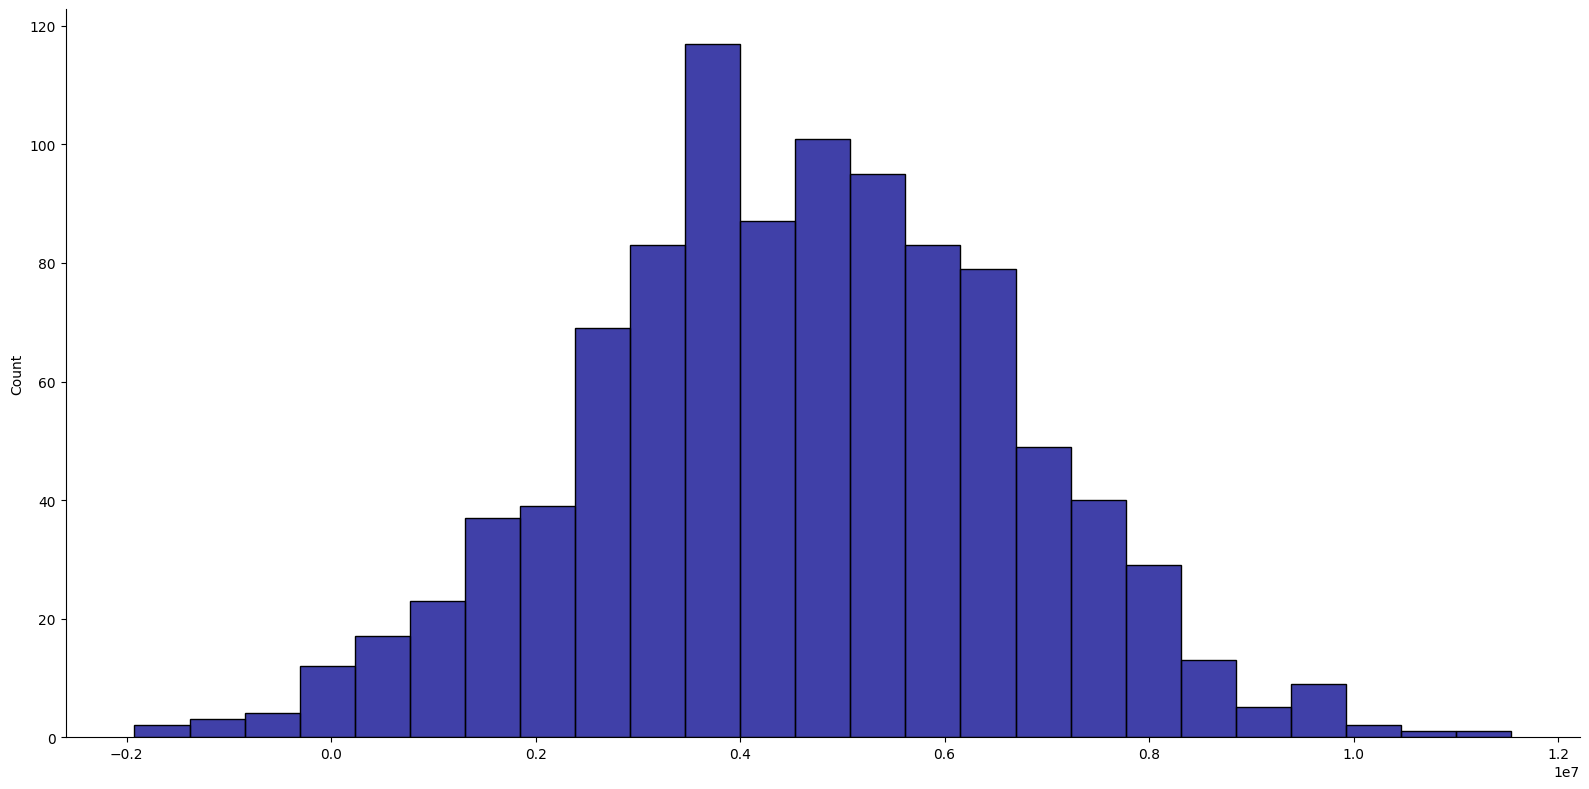

In [39]:
#confidence intervals/quantiles
state = np.random.RandomState(12345)

profit_1 = []
for i in range(1000):
    target_subsample_1 = target_valid_1.sample(n=500,replace=True, random_state=state)
    pred_subsample_1 = predicted_valid_1[target_subsample_1.index]
    #print(pred_subsample)
    profit_1.append(bootstrap(target_subsample_1, pred_subsample_1, 200))

profit_1 = pd.Series(profit_1)
neg_profit_1 = profit_1.where(profit_1 < 0).count()

#confidence interval target
confidence_interval = st.t.interval(confidence=0.95, df=len(profit_1)-1, loc=profit_1.mean(), scale=profit_1.sem())

#quantile view
lower = profit_1.quantile(0.025)
upper = profit_1.quantile(0.975)
print('')
print('\x1B[1m' + 'Lower Quantile:'+ '\x1B[0m', lower)
print('\x1B[1m' + 'Upper Quantile:'+ '\x1B[0m', upper)
print('\x1B[1m' + 'Mean:'+ '\x1B[0m', profit_1.mean())
print('\x1B[1m' + '95% confidence interval:'+ '\x1B[0m', confidence_interval)


print('')
average_profit_1 = profit_1.mean()
print('\x1B[1m' + 'Average Profit for Region 1:'+ '\x1B[0m')
print(revenue_format(average_profit_1))
print('')

print('\x1B[1m' + 'Profit Distribution for Region 1:'+ '\x1B[0m')
sns.displot(profit_1, color="darkblue", height=8, aspect=2)


Lower Quantile: -1633504.1339559986
Upper Quantile: 9503595.749237997
Mean: 4044038.665683568
95% confidence interval: (3874457.974712804, 4213619.356654332)

Average Profit for Region 2:
4.04M

Profit Distribution for Region 2:


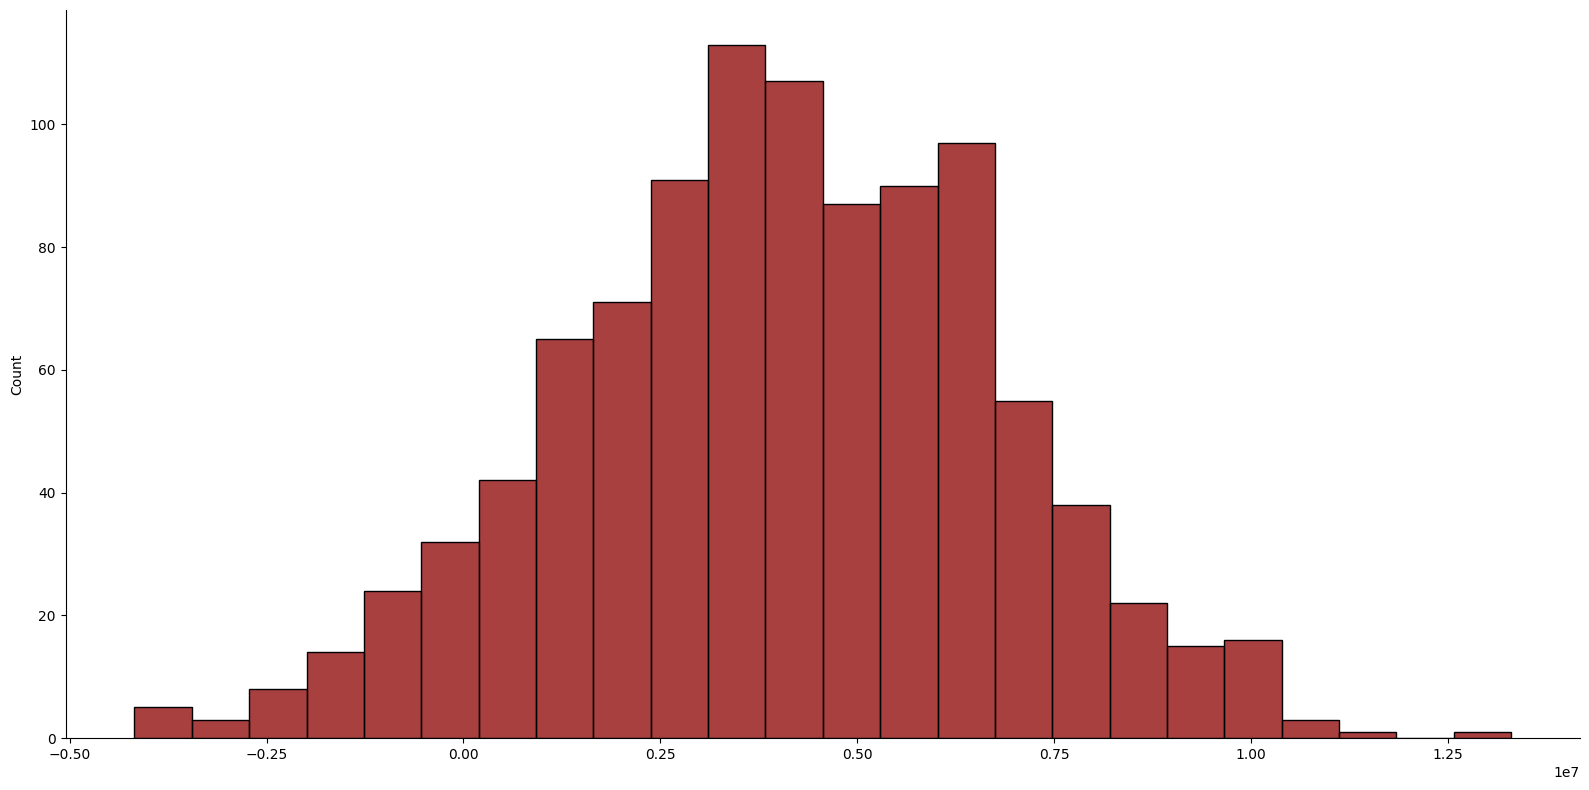

In [40]:
#confidence intervals/quantiles
state = np.random.RandomState(12345)

neg_pred_profit = (predicted_valid_2 < 0).sum().sum()

profit_2 = []
for i in range(1000):
    target_subsample_2 = target_valid_2.sample(n=500, replace=True, random_state=state)
    pred_subsample_2 = predicted_valid_2[target_subsample_2.index]
    profit_2.append(bootstrap(target_subsample_2, pred_subsample_2, 200))

profit_2 = pd.Series(profit_2)
neg_profit_2 = profit_2.where(profit_2 < 0).count()

#confidence interval target
confidence_interval = st.t.interval(confidence=0.95, df=len(profit_2)-1, loc=profit_2.mean(), scale=profit_2.sem())

#quantile view
lower = profit_2.quantile(0.025)
upper = profit_2.quantile(0.975)
print('')
print('\x1B[1m' + 'Lower Quantile:'+ '\x1B[0m', lower)
print('\x1B[1m' + 'Upper Quantile:'+ '\x1B[0m', upper)
print('\x1B[1m' + 'Mean:'+ '\x1B[0m', profit_2.mean())
print('\x1B[1m' + '95% confidence interval:'+ '\x1B[0m', confidence_interval)


print('')
average_profit_2 = profit_2.mean()
print('\x1B[1m' + 'Average Profit for Region 2:'+ '\x1B[0m')
print(revenue_format(average_profit_2))
print('')

print('\x1B[1m' + 'Profit Distribution for Region 2:'+ '\x1B[0m')
sns.displot(profit_2, color="darkred", height=8, aspect=2)

**`Risk of Losses:`**

In [41]:
#Loss = negative profit, calculate it as a probability and then express as a percentage.

print(f"Risk of Losses for Region 0: {(neg_profit_0/len(profit_0))*100}%")

print(f"Risk of Losses for Region 1: {(neg_profit_1/len(profit_1))*100}%")

print(f"Risk of Losses for Region 2: {(neg_profit_2/len(profit_2))*100}%")

#select regions with the risk of losses lower than 2.5%

Risk of Losses for Region 0: 6.9%
Risk of Losses for Region 1: 1.5%
Risk of Losses for Region 2: 7.6%


**`Findings and Oil Well Region Suggestion`**

1. Initial findings suggested the selection of Region 0 based on preliminary predictions and taking a look into the top 200 oil wells (by predictions). Region 0 was predicted to bring in the most revenue followed by Region 2 then Region 1 at the very end (a ~9M difference between 1st and last). Target reserve volume followed a slightly different path with Region 2 having the highest values followed by Region 0 then lastly, Region 1. 
    
    
2. Utilizing the bootstrapping technique, we see a shift in the story where Region 1 is predicted to bring in the highhest average revenue out of the three Regions. Region 0 shows us the lowest mean value out of the 3 with a average profit of 3.96M, while Region 1 is the highest at 4.56M (4.04M for Region 2). Region 1's average profit falls neatly in between a 95% confidence internal that's less 'spread out' compared to the other 2 regions. It is also the only region without a negative lower quantile.

    
3. Finally, the Region 1 'shift' from our intial observations is strengthed based on risk of loss probability condition that we should not be selecting anything higher than a 2.5% risk of loss percentage where Region 1 is the only region with the probability of losses being under our prescribed threshold. 

    
</div>